# Imports

Imported is the standard scientific toolkit, plus Tensorflow 2.


In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pickle

In [3]:
print('This code requires tensorflow >= 2.0.0. Your version:', tf.__version__)

This code requires tensorflow >= 2.0.0. Your version: 2.3.0


# Predictor setting


The COVID-19 crisis is proving to be one of the world’s most critical challenges — a challenge bigger than any one government or organization can tackle on its own. Right now, countries around the world are not equipped to implement health and safety interventions and policies that effectively protect both their citizens and economies.

 
In order to fight this pandemic, we need access to localized, data-driven planning systems and the latest in artificial intelligence (AI) to help decision-makers develop and implement robust Intervention Plans (IPs) that successfully reduce infection cases and minimize economic impact.

**Intervention Plan (IP)**: A plan of action or schedule for setting and resetting various intervention policies at various strengths or stringency.

**Predictor Model**: Given a time sequence of IPs in effect, and other data like a time sequence of number of cases, a predictor model will estimate the number of cases in the future.

## Intervention Plan

An intervention plan consists of a set of [containment and closure policies](https://github.com/OxCGRT/covid-policy-tracker/blob/master/documentation/codebook.md#containment-and-closure-policies), as well as [health system policies](https://github.com/OxCGRT/covid-policy-tracker/blob/master/documentation/codebook.md#health-system-policies). Check out the links to understand what these policies correspond to and how they are coded.

For instance the **C1_School closing** policy, which records closings of schools and universities, is coded like that:

| Code      | Meaning     |
| :-------- | :---------- |
|  0        | no measures |
|  1        | recommend closing|
|  2        | require closing (only some levels or categories, eg just high school, or just public schools) |
|  3        | require closing all levels |
| Blank     | no data |

Interventions plans are recorded daily for each countries and sometimes for regions. For this competition, the following policies are considered:

In [4]:
IP_COLUMNS = ['C1_School closing',
              'C2_Workplace closing',
              'C3_Cancel public events',
              'C4_Restrictions on gatherings',
              'C5_Close public transport',
              'C6_Stay at home requirements',
              'C7_Restrictions on internal movement',
              'C8_International travel controls',
              'H1_Public information campaigns',
              'H2_Testing policy',
              'H3_Contact tracing']

## Dataset

The university of Oxford Blavatnik School of Government is [tracking coronavirus government responses](https://www.bsg.ox.ac.uk/research/research-projects/coronavirus-government-response-tracker). They have assembled a [data set](https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv) containing historical data since January 1st, 2020 for the number of cases and IPs for most countries in the world.

In [5]:
DATA_URL = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'
df_all = pd.read_csv(DATA_URL,
                 parse_dates=['Date'],
                 encoding="ISO-8859-1",
                 error_bad_lines=False)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
df_all.sample(3)

,CountryName,CountryCode,RegionName,RegionCode,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,...,StringencyIndex,StringencyIndexForDisplay,StringencyLegacyIndex,StringencyLegacyIndexForDisplay,GovernmentResponseIndex,GovernmentResponseIndexForDisplay,ContainmentHealthIndex,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay
29341,Moldova,MDA,NaN,NaN,2020-08-26,3.0,1.0,2.0,1.0,2.0,...,57.41,57.41,60.71,60.71,58.33,58.33,62.12,62.12,37.5,37.5
13391,Ecuador,ECU,NaN,NaN,2020-02-11,0.0,NaN,0.0,NaN,0.0,...,5.56,5.56,9.52,9.52,3.85,3.85,4.55,4.55,0.0,0.0
37297,Paraguay,PRY,NaN,NaN,2020-07-03,3.0,1.0,2.0,1.0,2.0,...,81.48,81.48,88.10,88.10,78.21,78.21,78.79,78.79,75.0,75.0


## Preprocessing

### Add a 'GeoID' column

The data has both countries and regions columns. We will make a 'GeoID' column combining these.


In [7]:
def add_geoid(df):
    """Add a GeoID column to the dataframe in-place."""
    # Handle regions
    df["RegionName"].fillna('', inplace=True)

    # Add GeoID column that combines CountryName and RegionName for easier manipulation of data
    # np.where usage: if A then B else C
    df["GeoID"] = np.where(df["RegionName"] == '',
                           df["CountryName"],
                           df["CountryName"] + ' / ' + df["RegionName"])

add_geoid(df_all)

### Fill in missing data

In [8]:
# Fill any missing NPIs by assuming they are the same as previous day
for ip_col in IP_COLUMNS:
    df_all.update(df_all.groupby('GeoID')[ip_col].ffill().fillna(0))



### Computing the daily change in cases
The **ConfirmedCases** column reports the total number of cases since the beginning of the epidemic for each country, region and day. From this number we can compute the daily change in confirmed cases by doing:

\begin{equation*}
NewCases_t = ConfirmedCases_t - ConfirmedCases_{t-1}
\end{equation*}

Like this:

In [9]:
df_all["NewCases"] = df_all.groupby(["GeoID"]).ConfirmedCases.diff().fillna(0)

In [10]:
# Fill any missing case values by interpolation and setting NaNs to 0
df_all.update(df_all.groupby('GeoID').NewCases.apply(
    lambda group: group.interpolate()).fillna(0))

## Visualizing the data

### Listing the number of cases and IPs

Select columns of the DataFrame using indexing, and then sample 3 random rows.

In [11]:
ID_COLUMNS = ["CountryName", "RegionName", "GeoID", "Date"]
CASES_COLUMNS = ["NewCases", "ConfirmedCases"]


In [12]:
df_all[ID_COLUMNS + CASES_COLUMNS +  IP_COLUMNS].sample(3)


,CountryName,RegionName,GeoID,Date,NewCases,ConfirmedCases,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,C7_Restrictions on internal movement,C8_International travel controls,H1_Public information campaigns,H2_Testing policy,H3_Contact tracing
34458,Oman,,Oman,2020-01-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009,Argentina,,Argentina,2020-05-20,438.0,8796.0,3.0,2.0,2.0,4.0,2.0,2.0,2.0,4.0,2.0,1.0,2.0
20250,Guyana,,Guyana,2020-08-13,55.0,623.0,2.0,0.0,2.0,4.0,1.0,2.0,2.0,4.0,2.0,1.0,2.0


### Listing the latest historical daily new cases for a given country and region
For instance, for country **United States**, region **Texas**, the latest available changes in confirmed cases are:

In [13]:
geoid = 'United States / Texas'
country_region_df = df_all[df_all.GeoID == geoid]
country_region_df[["CountryName", "RegionName", "Date", "ConfirmedCases", "NewCases"]].tail(7)


,CountryName,RegionName,Date,ConfirmedCases,NewCases
59801,United States,Texas,2020-09-17,701350.0,4543.0
59802,United States,Texas,2020-09-18,704563.0,3213.0
59803,United States,Texas,2020-09-19,707940.0,3377.0
59804,United States,Texas,2020-09-20,713007.0,5067.0
59805,United States,Texas,2020-09-21,734778.0,21771.0
59806,United States,Texas,2020-09-22,NaN,0.0
59807,United States,Texas,2020-09-23,NaN,0.0


Note that the last few days don't have data recorded yet, and so the value in the ConfirmedCases column is NaN.

Here is all the data available for Texas:

<AxesSubplot:title={'center':'Daily new cases: United States / Texas'}, xlabel='Date'>

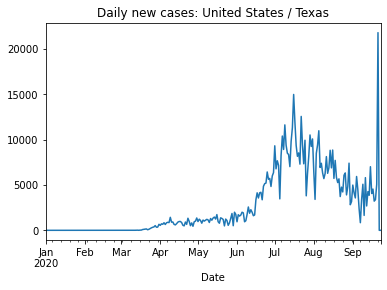

In [14]:
country_region_df.plot(title=f'Daily new cases: {geoid}',
                       x='Date',
                       y='NewCases',
                       legend=False)

# Prediction task

## Predictor input
The goal of a predictor is to predict the expected number of daily cases for countries and regions for a list of days, assumging the given daily IPs are in place:

In [15]:
EXAMPLE_INPUT_FILE = "2020-08-01_2020-08-04_npis_example.csv"
prediction_input_df = pd.read_csv(EXAMPLE_INPUT_FILE,
                                  parse_dates=['Date'],
                                  encoding="ISO-8859-1")
prediction_input_df.head()

,CountryName,RegionName,Date,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,C7_Restrictions on internal movement,C8_International travel controls,H1_Public information campaigns,H2_Testing policy,H3_Contact tracing
0,Aruba,NaN,2020-08-01,0.0,1.0,0.0,0.0,0.0,1.0,1.0,3.0,2.0,2.0,1.0
1,Aruba,NaN,2020-08-02,0.0,1.0,0.0,0.0,0.0,1.0,1.0,3.0,2.0,2.0,1.0
2,Aruba,NaN,2020-08-03,0.0,1.0,0.0,0.0,0.0,1.0,1.0,3.0,2.0,2.0,1.0
3,Aruba,NaN,2020-08-04,0.0,1.0,0.0,4.0,0.0,1.0,1.0,3.0,2.0,2.0,1.0
4,Afghanistan,NaN,2020-08-01,3.0,3.0,2.0,4.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0


## Predictor expected output
The output produced by the predictor should look like that:

In [16]:
EXAMPLE_OUTPUT_FILE = "2020-08-01_2020-08-04_predictions_example.csv"
prediction_output_df = pd.read_csv(EXAMPLE_OUTPUT_FILE,
                                   parse_dates=['Date'],
                                   encoding="ISO-8859-1")
prediction_output_df.head()

,CountryName,RegionName,Date,PredictedDailyNewCases
0,Aruba,NaN,2020-08-01,0.820071
1,Aruba,NaN,2020-08-02,0.872854
2,Aruba,NaN,2020-08-03,0.000000
3,Aruba,NaN,2020-08-04,0.000000
4,Afghanistan,NaN,2020-08-01,80.590128


## Make the holdout set

This cell defines a set of test input. Data prior to the test window is going to train your model. Data during the test window is not known, at least in theory; for this assignment, we are using data that already exists. 

The holdout set contains data from the last four weeks.

In [17]:
test_start_date = "2020-08-16"
test_end_date = "2020-09-13"
df_holdout = df_all[(df_all.Date >= test_start_date) & (df_all.Date < test_end_date)]
df_train = df_all[df_all.Date < test_start_date]

# Create the model


## Form the training data



The data is currently a pandas DataFrame representing a table with many columns. It is necessary to reduce this table to the relevant information and to format the data to be usable by the prediction model using a **sliding window**.




In [18]:
def create_training_data(days_ahead, lookback_days, df, cases_col, ip_cols):
    """Runs a sliding window across the input data to generate training samples.
    Each training sample is a vector consisting:
        (1) daily case data for a number of days equal to lookback_days.
        (2) daily IP data covering the same range as the daily case data,
            plus a number of days equal to days_ahead.
    The corresponding labels are the number of new cases starting the day after 
    the end of the input case data and ending on the final day of IP data.
    
    Specifically, for any valid day d:
        the cases are from days { d-lookback_days, ..., d-1 };
        the IPs are from days { d-lookback_days, ..., d, d+1, ..., d+days_ahead-1 };
        and the labels are for days { d, d+1, ..., d+days_ahead-1 }.
    
    Any given sample includes data from only one single GeoID.
    
    Arguments:
        days_ahead (int): A value 1 or above indicating the number of days ahead
            to predict past the end of the case data.
        lookback_days (int): A value 0 or above indicating the number of days
            of case data included.
        df (pandas.DataFrame): The dataframe to extract these features from.
        cases_col (str): The name of the DataFrame column corresponding
            to the case data.
        ip_cols (List[str]): The names of the DataFrame columns corresponding
            to the intervention plan data.
        
    Returns: A tuple (features, labels):
        features is an ndarray of shape (Samples, Features);
        labels is an ndarray of shape (Samples, PredictDays)"""
    X_samples = []
    y_samples = []
    geo_ids = df.GeoID.unique()
    for g in geo_ids:
        gdf = df[df.GeoID == g]
        all_case_data = np.array(gdf[cases_col], dtype=np.float32) # shape (Days,)
        all_ip_data = np.array(gdf[ip_cols], dtype=np.float32) # shape (Days, IPs)
        
        # Create one sample for each day where we have enough data
        total_days = len(gdf)
        for d in range(lookback_days, total_days - days_ahead):
            # Select the window
            X_cases = all_case_data[d - lookback_days:d]
            X_ips = all_ip_data[d - lookback_days:d + days_ahead]
            y_sample = all_case_data[d: d + days_ahead]

            # Flatten the daily data into one vector
            X_sample = np.concatenate([X_cases.flatten(),
                                       X_ips.flatten()])
            
            # Add it to the list of training samples
            X_samples.append(X_sample)
            y_samples.append(y_sample)

    X_samples = np.array(X_samples)
    y_samples = np.array(y_samples)
    
    X_size = X_samples.shape[0];
    y_size = y_samples.shape[0];
    
    X_dim = X_samples.shape[1];
    y_dim = y_samples.shape[1];
    
    new_X_samples = X_samples.reshape(X_size, 1 , X_dim)
    new_y_samples = y_samples.reshape(y_size, 1 , y_dim)
    return new_X_samples, new_y_samples

def split_by_geoid(df, split=0.2):
    """Splits the dataframe into two. This will select GeoIDs randomly
    and include a certain number in the first split and the rest in the other.
    
    Arguments:
        df (pd.DataFrame): The data to divide into two.
        split (float): The portion of data to be used in the first split."""
    geo_ids = df.GeoID.unique()
    np.random.shuffle(geo_ids)
    n_first = int(len(geo_ids) * split)
    geos_first = geo_ids[:n_first]
    geos_second = geo_ids[n_first:]
    df_first = df[df.GeoID.isin(geos_first)]
    df_second = df[df.GeoID.isin(geos_second)]
    return df_first, df_second


In [19]:
DAYS_AHEAD = 4 * 7 # The goal entails predicting four weeks of data.
LOOKBACK_DAYS = 30
CASES_COLUMN = "NewCases"

df_val, df_train = split_by_geoid(df_train, 0.2)
X_train, y_train = create_training_data(DAYS_AHEAD, LOOKBACK_DAYS, df_train, CASES_COLUMN, IP_COLUMNS)
X_val, y_val = create_training_data(DAYS_AHEAD, LOOKBACK_DAYS, df_val, CASES_COLUMN, IP_COLUMNS)

In [20]:
print(f'There are {X_train.shape[0]} training samples, and each has {X_train.shape[2]} feature dimensions.')
print(f'There are {X_val.shape[0]} validation samples.')
print(f'For each of the {y_train.shape[0]} training samples, ' +
      f'there are {y_train.shape[2]} days of cases to predict.')
print(f'There are {DAYS_AHEAD + LOOKBACK_DAYS} days of IP data, and {LOOKBACK_DAYS} days of case data, ' +
      f'making up {(DAYS_AHEAD + LOOKBACK_DAYS) * len(IP_COLUMNS) + LOOKBACK_DAYS} dimensions.')

There are 32810 training samples, and each has 668 feature dimensions.
There are 8160 validation samples.
For each of the 32810 training samples, there are 28 days of cases to predict.
There are 58 days of IP data, and 30 days of case data, making up 668 dimensions.


## Define the model

Below is a linear regression model. Using Tensorflow to train a linear regression model is not necessary, but this code is meant to be a placeholder for your design.

Modify this class to create your neural network model.


In [29]:
# Replace this with your own model!
class LinearRegressionModel(tf.keras.Model):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        
        # WRITE YOUR CODE HERE
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Conv1D(filters=500, kernel_size=1, activation='relu', input_shape=(1, 668)))
        self.model.add(tf.keras.layers.Conv1D(filters=500, kernel_size=1, activation='relu'))
        self.model.add(tf.keras.layers.Dropout(0.1))
        self.model.add(tf.keras.layers.Dense(
            input_dim/2,
            activation='relu'))
        self.model.add(tf.keras.layers.Dense(
            input_dim/4,
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(0.1)))
        
        # This is the weights of the linear regression model.
        # The L1 norm pulls some weights to zero, so that the weights at the end are sparse.
        # This is called a Lasso model.
        self.model.add(tf.keras.layers.Dense(
            output_dim,
            kernel_regularizer=tf.keras.regularizers.l1(0.1),))

        # Call the model with a dummy input to build it
        self(tf.zeros([1, 1, input_dim]))
        
    @tf.function
    def call(self, x):
        return self.model(x)


Next, we create an instance of the model.

In [30]:
n_features = X_train.shape[2]
n_predictions = y_train.shape[2]

# PUT YOUR MODEL CLASS HERE
model = LinearRegressionModel(n_features, n_predictions)

model.model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 1, 500)            334500    
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 1, 500)            250500    
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 500)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 1, 334)            167334    
_________________________________________________________________
dense_7 (Dense)              (None, 1, 167)            55945     
_________________________________________________________________
dense_8 (Dense)              (None, 1, 28)             4704      
Total params: 812,983
Trainable params: 812,983
Non-trainable params: 0
________________________________________________

You can access the weight array of the model like so:

In [31]:
model.weights

[<tf.Variable 'conv1d_7/kernel:0' shape=(1, 668, 500) dtype=float32, numpy=
 array([[[-0.00140087, -0.04362555, -0.01303634, ...,  0.00022133,
          -0.05145811,  0.02825989],
         [-0.02938547,  0.06869247,  0.04249872, ..., -0.0554408 ,
           0.02978929, -0.01454237],
         [-0.05534589, -0.06698701, -0.04393961, ..., -0.03332363,
          -0.02962123, -0.00427853],
         ...,
         [ 0.02996346,  0.00415675, -0.03757252, ...,  0.01418801,
           0.01997209, -0.05349495],
         [ 0.06204622,  0.00685558,  0.00300088, ..., -0.02479133,
          -0.04069649, -0.01904023],
         [-0.02283663, -0.03304544, -0.06899281, ..., -0.00978556,
          -0.04885882, -0.04785779]]], dtype=float32)>,
 <tf.Variable 'conv1d_7/bias:0' shape=(500,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

## Train the model

Below is a standard training loop, featuring validation / training sets, batching, and gradient descent.

It could be done with less code because these features are included in the Keras library: see https://www.tensorflow.org/guide/basic_training_loops. For better clarity, it's kept in this long form.





In [32]:
def shuffle_samples(X_samples, y_samples):
    """Shuffles the arrays, preserving (x, y) pairs."""
    indices = np.arange(X_samples.shape[0])
    np.random.shuffle(indices)
    return X_samples[indices], y_samples[indices]
    
def loss_fn(y_pred, y_true):
    """Mean squared error (MSE) loss function."""
    return tf.reduce_mean(tf.square(y_pred - y_true))

def train_model(X_train, y_train, X_val, y_val, model):    
    # Define training parameters
    learning_rate = 2e-3
    n_epochs = 100
    batch_size = 64
    trainer = tf.keras.optimizers.Adam(learning_rate)

    # Initialize logging
    train_loss_log = []
    val_loss_log = []
    
    # Train loop
    n_train = X_train.shape[0]
    for epoch in range(n_epochs):
        X_train, y_train = shuffle_samples(X_train, y_train)
        
        # Minibatching
        batch_loss = []
        for index in np.arange(0, n_train, batch_size):
            batch_X = X_train[index:index + batch_size]
            batch_y = y_train[index:index + batch_size]

            # Calculate predictions and loss
            with tf.GradientTape() as g:
                y_pred = model(batch_X)
                loss = loss_fn(y_pred, batch_y)
                # Add the regularization
                loss += tf.reduce_sum(model.losses)
                
            # Backpropagate
            grads = g.gradient(loss, model.weights)
            trainer.apply_gradients(zip(grads, model.weights))
            
            # Logging
            batch_loss.append(loss.numpy())
        
        ## Logging: Calculate the mean loss over all batches
        train_loss = np.mean(batch_loss)
        
        ## Logging: Get validation loss
        val_pred = model(X_val)
        val_loss = loss_fn(val_pred, y_val).numpy()
        
        ## Logging
        train_loss_log.append(train_loss)
        val_loss_log.append(val_loss)
        print(f'Epoch {epoch}: Train Set Loss {train_loss:.2f}; Validation Set Loss: {val_loss:.2f}')

    return model, train_loss_log, val_loss_log

The following cell executes the train function, and it might take a while to execute.



You can set the LOAD_SAVED_MODEL flag to avoid training by loading the last created model.



In [33]:
LOAD_SAVED_MODEL = False


MODEL_FILE = 'model_weights'
TRAINING_LOG_FILE = 'training_log.pkl'
if LOAD_SAVED_MODEL:
    model.load_weights(MODEL_FILE)
    with open(TRAINING_LOG_FILE, 'rb') as f:
        train_log = pickle.load(f)
    train_loss_log = train_log['train_loss_log']
    val_loss_log = train_log['val_loss_log']
else:
    # Do the training
    model, train_loss_log, val_loss_log = train_model(X_train, y_train, X_val, y_val, model)
    
    # Save the weights and logs
    model.save_weights(MODEL_FILE)
    train_log = {
        'train_loss_log': train_loss_log,
        'val_loss_log': val_loss_log
    }
    with open(TRAINING_LOG_FILE, 'wb') as f:
        pickle.dump(train_log, f)
    


Epoch 0: Train Set Loss 4081421.75; Validation Set Loss: 1535061.00
Epoch 1: Train Set Loss 2812551.75; Validation Set Loss: 842252.00
Epoch 2: Train Set Loss 1759090.50; Validation Set Loss: 1581397.88
Epoch 3: Train Set Loss 2158800.25; Validation Set Loss: 840881.44
Epoch 4: Train Set Loss 1879900.12; Validation Set Loss: 1345499.00
Epoch 5: Train Set Loss 1688200.75; Validation Set Loss: 2589896.25
Epoch 6: Train Set Loss 1638267.88; Validation Set Loss: 1860540.25
Epoch 7: Train Set Loss 1707703.88; Validation Set Loss: 1366895.00
Epoch 8: Train Set Loss 1408843.62; Validation Set Loss: 1053067.25
Epoch 9: Train Set Loss 1480630.12; Validation Set Loss: 1246046.75
Epoch 10: Train Set Loss 1429688.38; Validation Set Loss: 1003965.81
Epoch 11: Train Set Loss 1422628.00; Validation Set Loss: 1290740.12
Epoch 12: Train Set Loss 1386455.50; Validation Set Loss: 952131.81
Epoch 13: Train Set Loss 1813109.00; Validation Set Loss: 779007.31
Epoch 14: Train Set Loss 1626906.75; Validation 

## Evaluate the model
The model is trained. The following cells are simple analyses.

### Visualize the weights

Since training was done with a L1 regularizer, the weight matrix is sparse. Below is shown the weight matrix indicating the features which weight the prediction one week ahead. 

In [34]:
weights = model.weights[0][:, 6].numpy().copy()
weights[np.abs(weights) < 0.1] = 0 # Set to the weights below 0.1 to zero to illustrate.
weights

array([[ 0.        , -0.9801193 ,  0.        ,  0.10493082, -0.17023967,
         0.        , -0.24674307,  0.        , -0.38629234, -0.33820042,
        -0.2055374 ,  0.        , -0.26224288, -0.12425015, -0.77709055,
         0.18469287,  0.        , -0.6533011 , -1.1215473 , -0.13970825,
        -0.882806  ,  0.        , -0.40683636,  0.1425902 , -0.3902792 ,
        -1.0543292 , -0.64774895,  0.        , -0.19609638,  0.20993625,
         0.        , -0.45466557, -0.16047718,  0.        , -0.3513043 ,
        -0.15631574,  0.24327955,  0.        ,  0.        , -0.15081632,
        -0.6824881 ,  0.        ,  0.        , -0.11847239,  0.        ,
         0.        ,  0.18812665,  0.        ,  0.        , -0.25770378,
         0.        , -0.1573677 ,  0.        ,  0.15470734, -0.19389258,
        -0.22832501,  0.        , -0.27239662,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , -0.12218879,  0.        ,
         0.        ,  0.15754813, -0.1627097 , -0.6

### Training curve
The training curve shows the progression of model performance over the course of training.

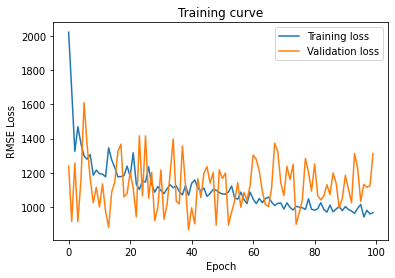

In [35]:
plt.figure()
plt.title('Training curve')
plt.xlabel('Epoch')
plt.ylabel('RMSE Loss')

# Convert the MSE loss values to RMSE
rmse_train_loss_log = np.sqrt(train_loss_log)
rmse_val_loss_log = np.sqrt(val_loss_log)

plt.plot(rmse_train_loss_log, label='Training loss')
plt.plot(rmse_val_loss_log, label='Validation loss')
plt.legend()



### Model output for a training sample
Here we'll construct a data sample, generate the model predictions for that sample, and then compare the model predictions to the real number of cases.


In [60]:
def make_prediction(ip_array, case_array, model):
    """Run a single instance of the prediction task.
    
    Arguments:
        ip_array (np.ndarray): An array of IPs; shape (Lookback + DaysAhead, N_IPs)
        case_array (np.ndarray): An array of known cases; shape (Lookback,)
        model (keras.Model): A callable model
    
    Returns:
        predictions (np.ndarray): An array of case predictions; shape (DaysAhead,)"""
    X_sample = np.concatenate([case_array.flatten(),
                               ip_array.flatten()])
    X_sample = X_sample[None] # Shape (1, Features)
    return model(X_sample.reshape(1,1,668))[0][0]

<AxesSubplot:title={'center':'Predicted and actual cases for United States / Texas'}, xlabel='Date'>

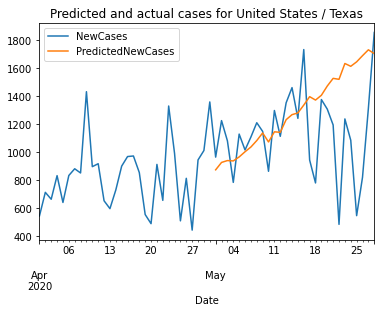

In [61]:
# Select the data for a sample region
geo_id = 'United States / Texas'
gdf = df_train[df_train.GeoID == geo_id]

# Slice a window of sample data
sample_test_begin = "2020-05-01"
d = pd.to_datetime(sample_test_begin)

ip_start = d - pd.DateOffset(days=LOOKBACK_DAYS)
ip_end = d + pd.DateOffset(days=DAYS_AHEAD)
ip_array = gdf[(gdf.Date >= ip_start) & (gdf.Date < ip_end)]
ip_array = np.array(ip_array[IP_COLUMNS], dtype=np.float32)

cases_start = d - pd.DateOffset(days=LOOKBACK_DAYS)
cases_end = d
cases_array = gdf[(gdf.Date >= cases_start) & (gdf.Date < cases_end)]
cases_array = np.array(cases_array[CASES_COLUMN], dtype=np.float32)

# Run the model to predict a number of cases for each day
predicted_cases = make_prediction(ip_array, cases_array, model)

# Plot the results
window_start = d - pd.DateOffset(days=LOOKBACK_DAYS)
window_end = d + pd.DateOffset(days=DAYS_AHEAD)
window = gdf[(gdf.Date >= ip_start) & (gdf.Date < ip_end)]

pred_df = window.copy()
predicted_cases = np.concatenate((
    np.full(len(window)-len(predicted_cases), np.nan),
    predicted_cases))
pred_df['PredictedNewCases'] = predicted_cases
pred_df.plot(x='Date', y=['NewCases', 'PredictedNewCases'], title=f'Predicted and actual cases for {geo_id}')


# Final predictions

Is your model ready to submit? If so, then this cell will evaluate its predictions on the test set. 

Making predictions means saving a .csv file called "start_date_end_date.csv" to the root folder.
For instance, if:

```
start_date = "2020-08-01"
end_date = "2020-08-04"
```

Then the expected output file is **2020-08-01_2020-08-04.csv**




Predicting for India

Predicting for Mexico
Predictions saved to 2020-08-16_2020-09-13.csv


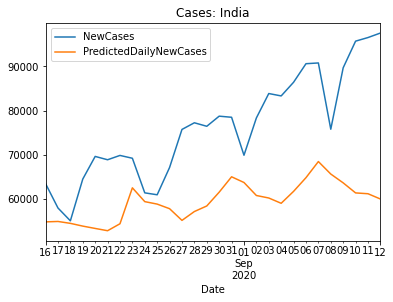

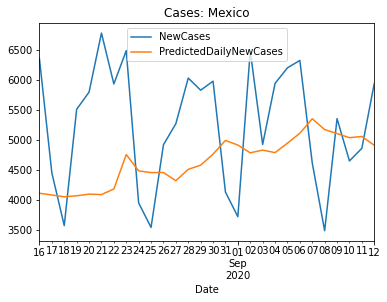

In [63]:
# SET THIS WHEN YOU ARE READY
READY_FOR_TESTING = True


TEST_INPUT_FILE = 'holdout_inputs.csv'

def write_testing_input(df: pd.DataFrame, filename: str):
    """Creates a simple 
    Arguments:
        df - the testing DataFrame"""
    ID_A = 'Mexico'
    ID_B = 'India'
    INPUT_COLUMNS = ["CountryName", "RegionName", "Date"] + IP_COLUMNS
    gdf = df[(df.GeoID == ID_A) | (df.GeoID == ID_B)]
    gdf = gdf[INPUT_COLUMNS]
    gdf.to_csv(TEST_INPUT_FILE, index=None)

def predict(start_date: str, end_date: str, path_to_ips_file: str):
    """
    Generates a file with daily new cases predictions for the given countries, regions and npis, between
    start_date and end_date, included.
    :param start_date: day from which to start making predictions, as a string, format YYYY-MM-DDD
    :param end_date: day on which to stop making predictions, as a string, format YYYY-MM-DDD
    :param path_to_ips_file: path to a csv file containing the intervention plans between start_date and end_date
    :return: Nothing. Saves a csv file called 'start_date_end_date.csv'
    with columns "CountryName,RegionName,Date,PredictedDailyNewCases"
    """
    # Read the IPs for the testing period
    test_df = pd.read_csv(path_to_ips_file, 
                 parse_dates=['Date'],
                 encoding="ISO-8859-1",
                 error_bad_lines=False)
    add_geoid(test_df)

    # Prepare the lookback data to include information prior to the testing period
    hist_df = df_all[df_all.Date < start_date]
    
    # Include only testing data from the testing period
    test_df = test_df[(test_df.Date >= start_date) & (test_df.Date <= end_date)]
    
    # Make case predictions for each GeoID in the testing data
    geo_pred_dfs = []
    for g in test_df.GeoID.unique():
        print('\nPredicting for', g)

        # Pull out all relevant data for country c
        hist_gdf = hist_df[hist_df.GeoID == g]
        test_gdf = test_df[test_df.GeoID == g]
        
        X_cases = np.array(hist_gdf[CASES_COLUMN], dtype=np.float32)[-LOOKBACK_DAYS:] # shape (Lookback,)
        X_hist_ips = np.array(hist_gdf[IP_COLUMNS], dtype=np.float32)[-LOOKBACK_DAYS:] # shape (Lookback, IPs)
        future_ip_data = np.array(test_gdf[IP_COLUMNS], dtype=np.float32) # shape (DaysAhead, IPs)

        # If IP data is missing, assume the IPs are kept the same
        n_days_predicted = future_ip_data.shape[0]
        if n_days_predicted < DAYS_AHEAD:
            n_fill_days = DAYS_AHEAD - n_days_predicted
            final_day_ips = future_ip_data[-1]
            filled_data = np.repeat(final_day_ips[np.newaxis], n_fill_days, axis=0)
            future_ip_data = np.concatenate((future_ip_data, filled_data), axis=0)
        
        # Prepare data
        X_future_npis = future_ip_data[:DAYS_AHEAD]
        X_ips = np.concatenate([X_hist_ips, X_future_npis])
        
        # Make the prediction
        geo_preds = make_prediction(X_ips, X_cases, model)
        geo_preds = geo_preds[:n_days_predicted]

        # Create geo_pred_df with pred column
        geo_pred_df = test_gdf[ID_COLUMNS].copy()
        geo_pred_df['PredictedDailyNewCases'] = geo_preds
        geo_pred_dfs.append(geo_pred_df)

    # Combine all predictions into a single dataframe
    pred_df = pd.concat(geo_pred_dfs)
    
    # Drop GeoID column to match expected output format
    pred_df = pred_df.drop(columns=['GeoID'])
    pred_df
    
    # Write predictions to csv
    # Save to expected file name
    output_file_name = start_date + "_" + end_date + ".csv"
    pred_df.to_csv(output_file_name, index=None)
    print(f"Predictions saved to {output_file_name}")
    
def plot_final_results(start_date, end_date):
    # If prediction worked ok, it generated the following file:
    output_file = start_date + "_" + end_date + ".csv"
    # That we can readd like this:
    prediction_output_df = pd.read_csv(output_file,
                                       parse_dates=['Date'],
                                       encoding="ISO-8859-1")
    prediction_output_df.head()
    
    add_geoid(prediction_output_df)
    
    regions = prediction_output_df.GeoID.unique()
    for g in regions:
        gdf = prediction_output_df[prediction_output_df.GeoID == g].copy()
        
        # Add the existing case data (the real counts) to this df
        # Assign the numpy array to bypass index
        gdf_holdout = df_holdout[df_holdout.GeoID == g]
        gdf['NewCases'] = gdf_holdout['NewCases'].to_numpy() 

        # Also get the case data from the end of the training data
        gdf_hist = df_train[df_train.GeoID == g].tail(LOOKBACK_DAYS)
        gdf = pd.concat([gdf_hist, gdf], ignore_index=True)
        
        gdf.plot(x='Date', y=['NewCases', 'PredictedDailyNewCases'], title=f'Cases: {g}')
        
    
if READY_FOR_TESTING:
    write_testing_input(df_holdout, TEST_INPUT_FILE)
    predict(test_start_date, test_end_date, TEST_INPUT_FILE)
    plot_final_results(test_start_date, test_end_date)
    